In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.19.0'

In [3]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-k46btmga
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-k46btmga
  Resolved https://github.com/tensorflow/docs to commit e21d085d5ed82504ffcec11aa82ebc78f1f2302e
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2025.3.6.10029-py3-none-any.whl size=186351 sha256=0c34c2c2ea736cf4fe5510ae462b0c7436428b2bde43b5a43a1b442dbda4c6c3
  Stored in directory: /tmp/pip-ephem-wheel-cache-uvuh7dmu/wheels/3e/88/34/48d2789bc9d37b33ddce06bccc454fae0285e5396d0a5be9d9
Successfully built tensorflow-docs


In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [5]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [8]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


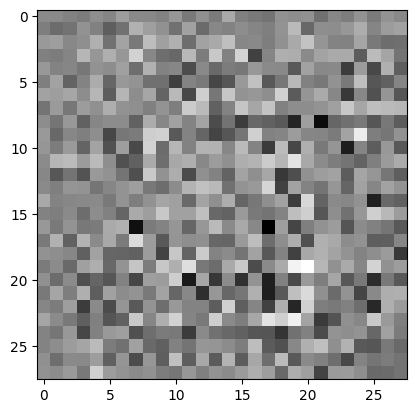

In [10]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [12]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[-0.00331897]], shape=(1, 1), dtype=float32)


In [13]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [18]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [19]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [20]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    # display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  # display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [21]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

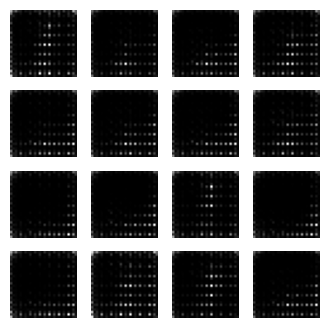

Time for epoch 1 is 41.512364625930786 sec


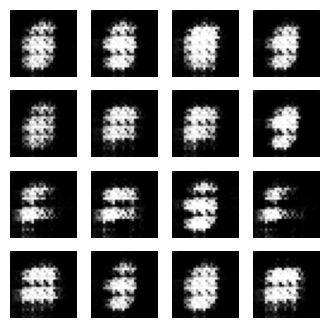

Time for epoch 2 is 12.868218898773193 sec


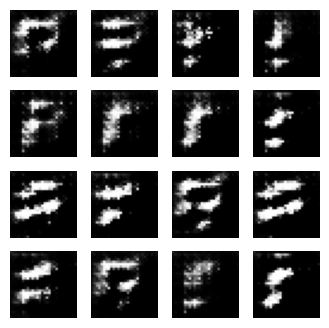

Time for epoch 3 is 12.971028566360474 sec


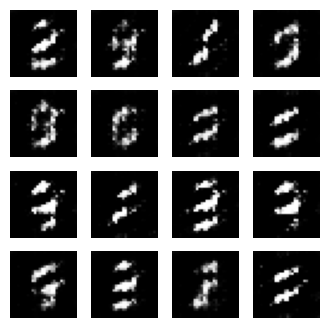

Time for epoch 4 is 13.403157949447632 sec


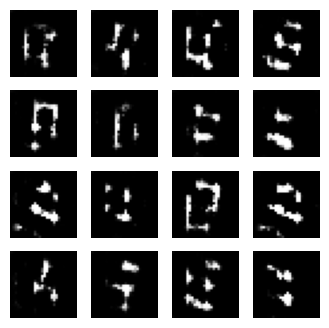

Time for epoch 5 is 13.294790506362915 sec


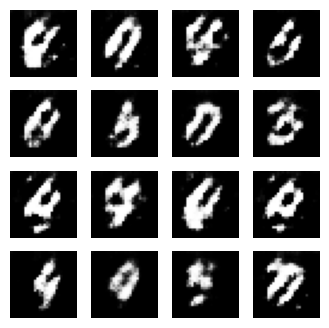

Time for epoch 6 is 13.452869176864624 sec


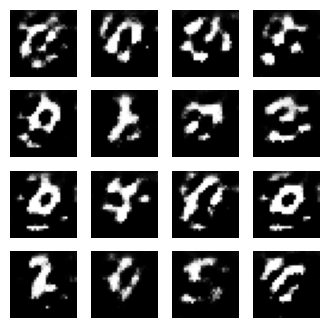

Time for epoch 7 is 13.467377662658691 sec


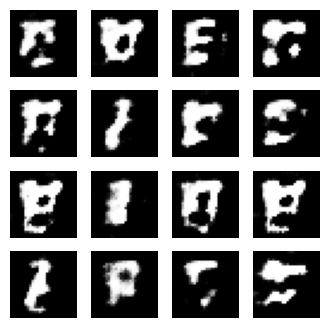

Time for epoch 8 is 13.146721839904785 sec


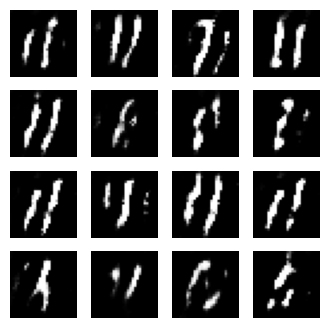

Time for epoch 9 is 13.12352705001831 sec


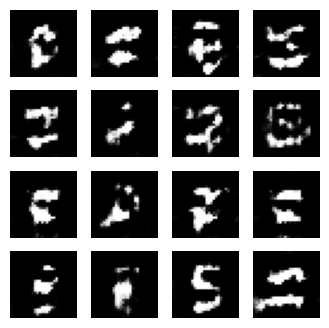

Time for epoch 10 is 13.1309072971344 sec


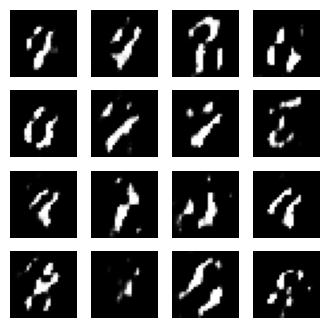

Time for epoch 11 is 13.476233720779419 sec


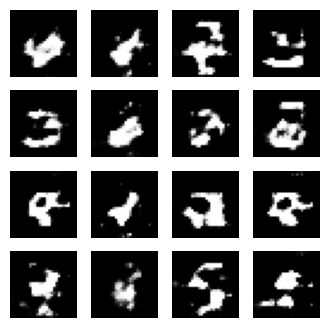

Time for epoch 12 is 13.232011079788208 sec


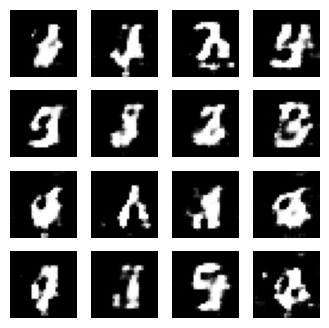

Time for epoch 13 is 13.205699443817139 sec


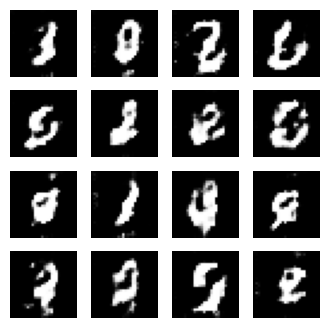

Time for epoch 14 is 13.20341157913208 sec


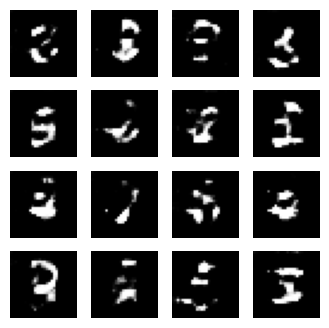

Time for epoch 15 is 13.50782585144043 sec


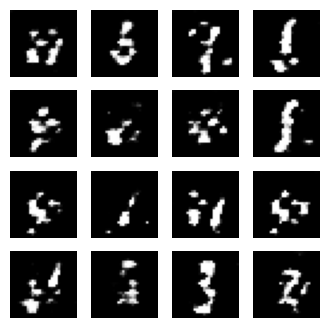

Time for epoch 16 is 13.190398693084717 sec


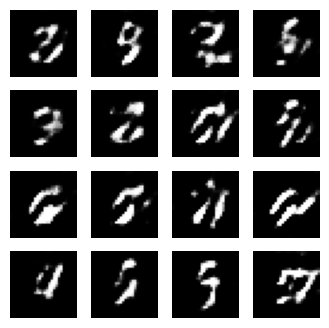

Time for epoch 17 is 13.499018907546997 sec


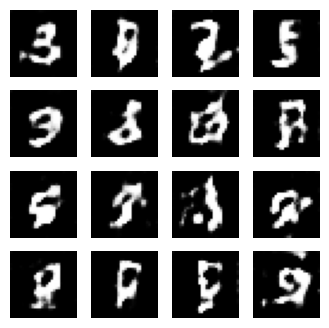

Time for epoch 18 is 13.22204875946045 sec


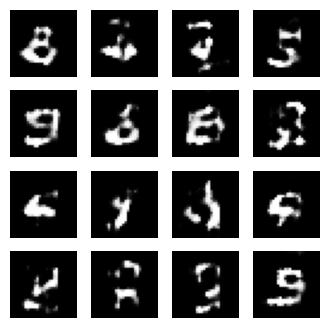

Time for epoch 19 is 13.225222110748291 sec


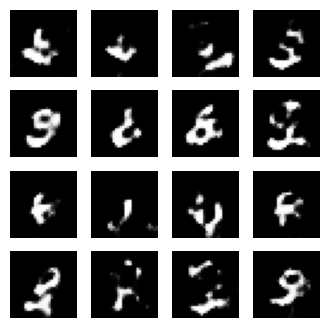

Time for epoch 20 is 13.21445369720459 sec


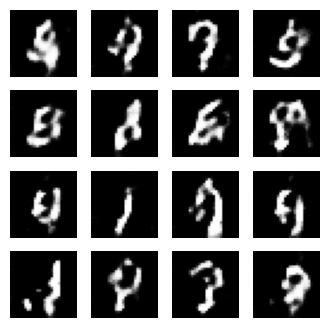

Time for epoch 21 is 13.206793546676636 sec


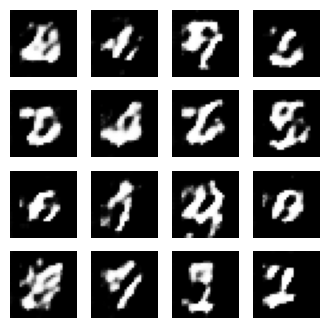

Time for epoch 22 is 13.174060344696045 sec


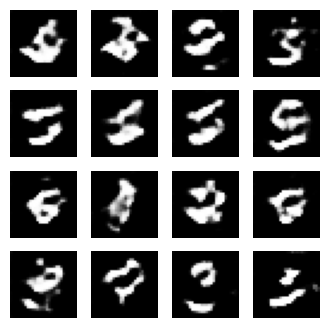

Time for epoch 23 is 13.519931554794312 sec


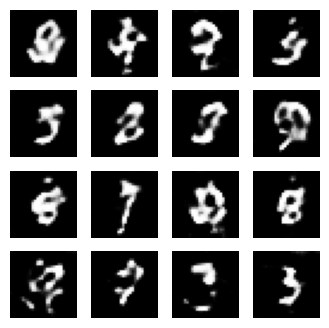

Time for epoch 24 is 13.3197603225708 sec


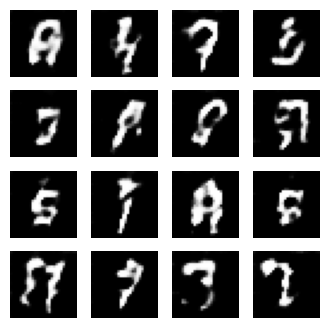

Time for epoch 25 is 13.267343521118164 sec


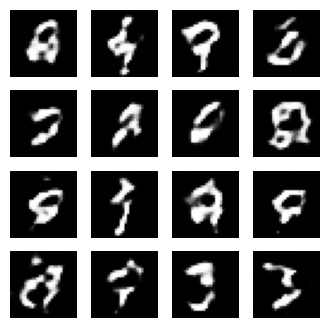

Time for epoch 26 is 13.207594156265259 sec


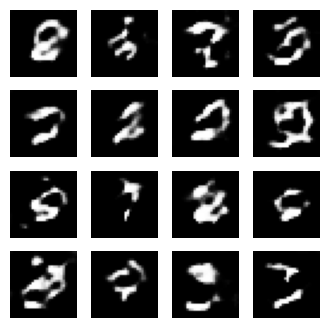

Time for epoch 27 is 13.218523502349854 sec


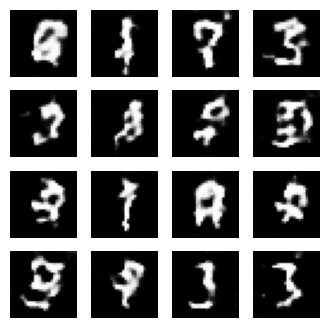

Time for epoch 28 is 13.225352048873901 sec


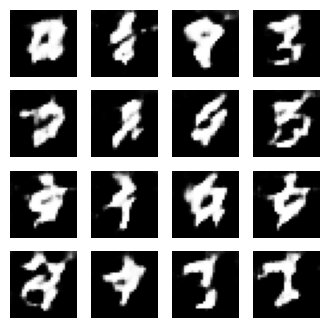

Time for epoch 29 is 13.5050630569458 sec


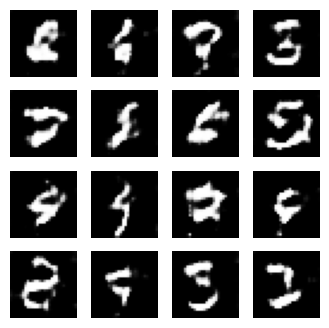

Time for epoch 30 is 13.336615085601807 sec


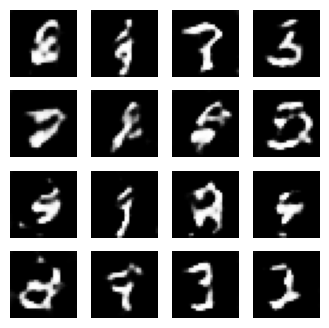

Time for epoch 31 is 13.19956636428833 sec


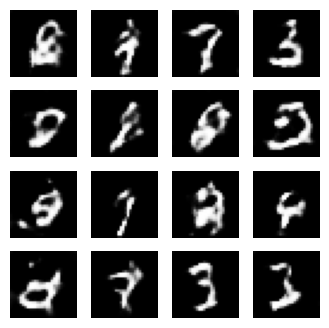

Time for epoch 32 is 13.311694622039795 sec


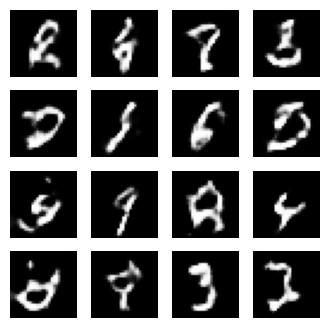

Time for epoch 33 is 13.33041787147522 sec


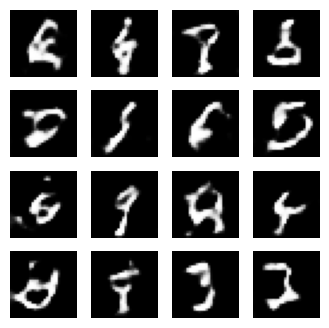

Time for epoch 34 is 13.225486755371094 sec


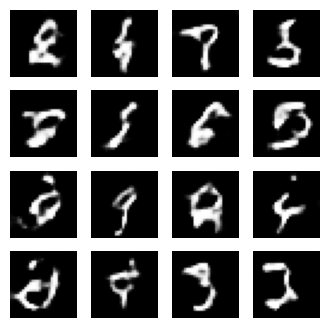

Time for epoch 35 is 13.194588899612427 sec


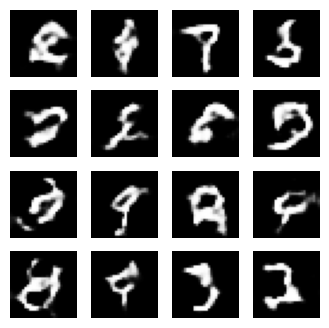

Time for epoch 36 is 13.460001945495605 sec


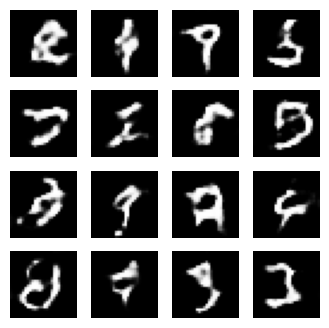

Time for epoch 37 is 13.209766387939453 sec


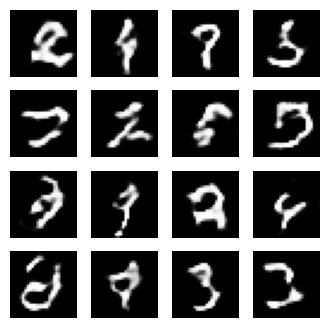

Time for epoch 38 is 13.211616039276123 sec


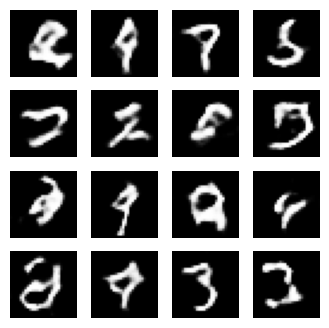

Time for epoch 39 is 13.226772785186768 sec


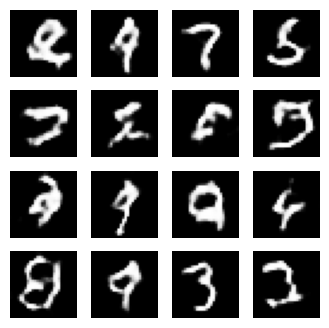

Time for epoch 40 is 13.22469186782837 sec


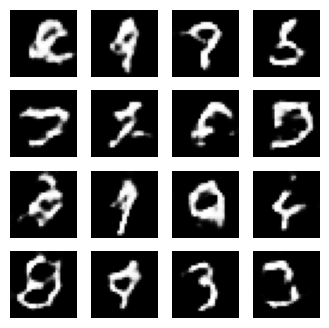

Time for epoch 41 is 13.33402156829834 sec


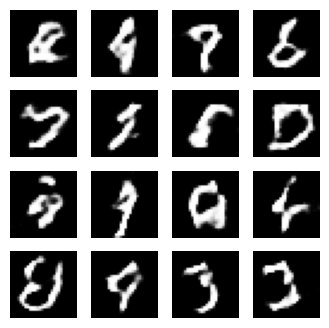

Time for epoch 42 is 13.565944194793701 sec


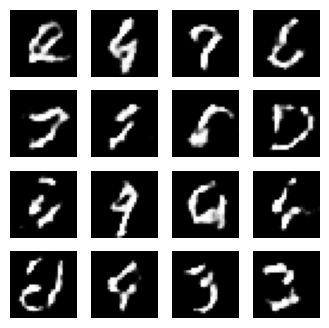

Time for epoch 43 is 13.210325956344604 sec


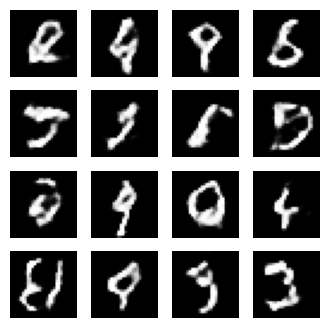

Time for epoch 44 is 13.226375102996826 sec


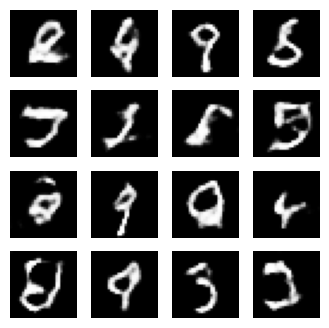

Time for epoch 45 is 13.357990741729736 sec


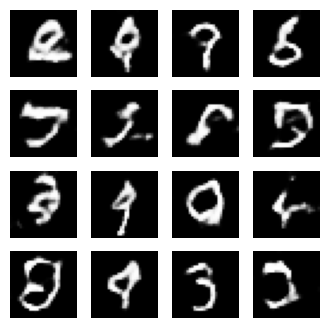

Time for epoch 46 is 13.242566585540771 sec


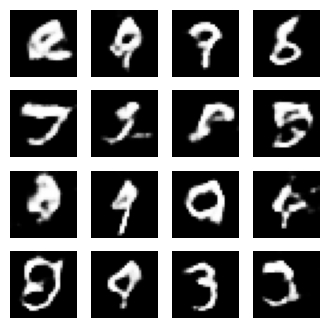

Time for epoch 47 is 13.22094440460205 sec


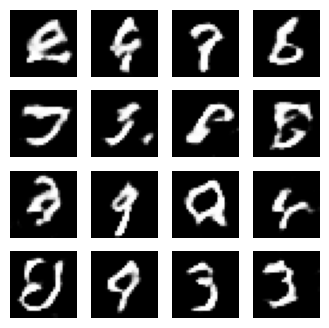

Time for epoch 48 is 13.52785587310791 sec


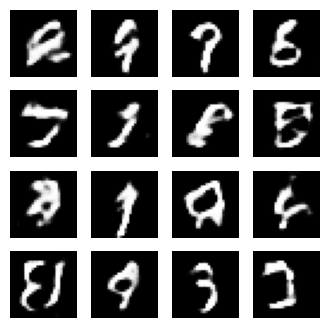

Time for epoch 49 is 13.285894632339478 sec


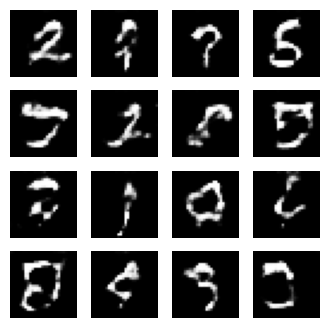

Time for epoch 50 is 13.408785581588745 sec


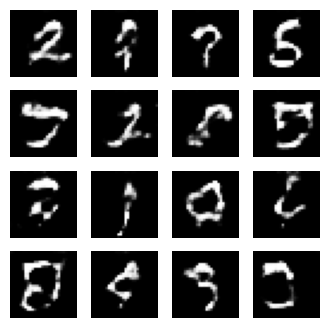

In [22]:
train(train_dataset, EPOCHS)

In [23]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [24]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

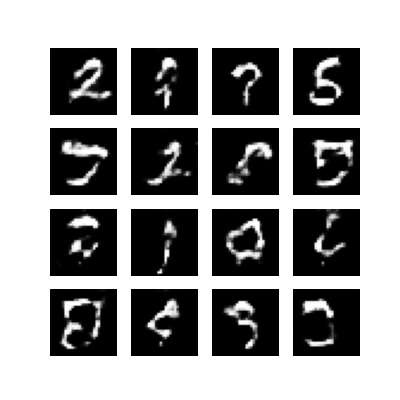

In [25]:
display_image(EPOCHS)

In [26]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

/tmp/ipython-input-1982054950.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/tmp/ipython-input-1982054950.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



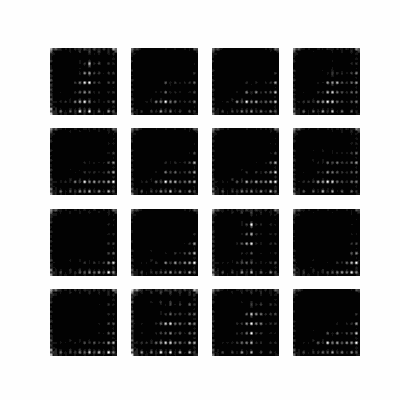

In [27]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)